Set Result directory and kidnapping step.

In [123]:
##  For env2 episode 7
target_episode_folders = {
    "Model 2":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/RSSM_node_MRSSM_replace/Path G",
    "Model 1":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/RSSM_node_replace/Path G",
    "MCL":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/record_amcl_none/Path G",
    "EMCL":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/emcl/Path 7",
}
kinapping_step = 132

##  For env2 episode 6
# target_episode_folders = {
#     "Model 2":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/RSSM_node_MRSSM_replace/Path F",
#     "Model 1":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/RSSM_node_replace/Path F",
#     "MCL":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/record_amcl_none/Path F",
#     "EMCL":"/root/TurtleBot3/catkin_ws/result/eval/env2/npy/emcl/Path 6",
# }
# kinapping_step=76

# ##  For env1 episode 10
# target_episode_folders = {
#     "Model 2":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/RSSM_node_MRSSM_replace/Path J",
#     "Model 1":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/RSSM_node_replace/Path J",
#     "MCL":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/record_amcl_none/Path J",
#     "EMCL":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/emcl/Path 10",
# }
# kinapping_step = 32

##  For env1 episode 11
# target_episode_folders = {
#     "Model 2":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/RSSM_node_MRSSM_replace/Path K",
#     "Model 1":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/RSSM_node_replace/Path K",
#     "MCL":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/record_amcl_none/Path K",
#     "EMCL":"/root/TurtleBot3/catkin_ws/result/eval/env1_Reproduction/npy/emcl/Path 11",
# }
# kinapping_step = 44


Calc SR and SPL

In [124]:
import numpy as np

def return_success(grand_truth,pose):
    # conditions for successful localization recovery:
    success_distance = 0.5
    success_rotation = 0.1
    distance_to_grand_truth = np.linalg.norm(grand_truth[:2] - pose[:2])
    rotation_to_grand_truth = np.arctan2(grand_truth[-2],grand_truth[-1]) - np.arctan2(pose[-2],pose[-1])
    rotation_to_grand_truth = np.mod(rotation_to_grand_truth + np.pi, 2 * np.pi) - np.pi

    if distance_to_grand_truth < success_distance and abs(rotation_to_grand_truth) < abs(success_rotation):
        metric = 1.0
    else:
        metric = 0.0

    return metric



In [125]:
def are_lengths_equal(two_dim_list):
    if not two_dim_list:  # 空のリストの場合
        return True

    # 最初のサブリストの長さを取得
    first_length = len(two_dim_list[0])

    # すべてのサブリストが最初のサブリストと同じ長さかどうかをチェック
    for sublist in two_dim_list:
        if len(sublist) != first_length:
            return False

    return True

Load result log

In [126]:
import glob

# save_data = [["Path", "Average", "std", "std_error", "Num", "平均(標準偏差)","best", "worst","median"]]

position_sequences = {} 
rmse_sequences={}
success_sequences={}

for key, folder in target_episode_folders.items():
    # Load data
    files = glob.glob(folder +"/*"+".npy")
    if len(files) == 0:
        continue
    position_data={"pose_t-1":[],
                   "grand_pose_t":[]
                    }

    for file in files:
        data_np = np.load(file, allow_pickle=True).item()
        position_data["pose_t-1"].append(data_np["pose_t-1"])
        position_data["grand_pose_t"].append(data_np["grand_pose_t"])

    max_len = max(len(arr) for arr in position_data["pose_t-1"])
    min_len = min(len(arr) for arr in position_data["pose_t-1"])
    print(key,": max_len", max_len, "   / min_len", min_len)
    
    # Padding for same length
    for i, arr in enumerate(position_data["pose_t-1"]):
        while len(position_data["pose_t-1"][i]) < max_len:
            # 先頭から2番目の要素があるかチェック
            if len(arr) > 1:
                insert_value_p = arr[1]  # 2番目の要素
                insert_value_gp = position_data["grand_pose_t"][i][1]  # 2番目の要素
            else:
                insert_value_p = None  # 要素がない場合はNoneを追加
            # 2番目の位置に追加
            position_data["pose_t-1"][i].insert(1, insert_value_p)
            position_data["grand_pose_t"][i].insert(1, insert_value_gp)

    max_len = max(len(arr) for arr in position_data["pose_t-1"])
    min_len = min(len(arr) for arr in position_data["pose_t-1"])
    print(key,": max_len", max_len, "   / min_len", min_len)
    
    position_sequences[key] = position_data
    
    # Culc RMSE and success
    mse_list=[]
    success_list = []
    average_array=np.zeros(len(position_data["grand_pose_t"]))
    for j,(grand_truth , pose) in enumerate(zip(position_data["grand_pose_t"], position_data["pose_t-1"])):
        if len(grand_truth) != len(pose):
            print("error")
            print(len(grand_truth), len(pose))
            exit()

        mse_list.append([])
        success_list.append([])
        for i in range(len(grand_truth)-1):
            data_pose = pose[i+1]
            data_grand_pose = grand_truth[i]
            mse_list[j].append(np.sqrt(np.mean((data_grand_pose - data_pose) ** 2)))
            success_list[j].append(return_success(data_grand_pose,data_pose))
            # culc_data[file][i-1] = np.sqrt(np.mean((data_grand_pose - data_pose) ** 2))
        average_array[j]= sum(mse_list[j]) / len(mse_list[j])

    rmse_sequences[key] = mse_list
    success_sequences[key] = success_list


Model 2 : max_len 257    / min_len 257
Model 2 : max_len 257    / min_len 257
Model 1 : max_len 257    / min_len 257
Model 1 : max_len 257    / min_len 257
MCL : max_len 257    / min_len 257
MCL : max_len 257    / min_len 257
EMCL : max_len 257    / min_len 257
EMCL : max_len 257    / min_len 257


In [134]:
import statistics

def sum_of_inverses(numbers):
    if 0 in numbers:
        raise ValueError("Cannot compute the inverse of zero.")
    return sum(1/x for x in numbers)


# average_steps_for_recovery and success_recovery_rate
for key, success_list in success_sequences.items():
    recovery_steps = []
    for i, success in enumerate(success_list):
        # recovery = False
        for j, s in enumerate(success):
            if s == 1 and j > kinapping_step:
                recovery_steps.append(j - kinapping_step)
                # recovery = True
                break
        # if not recovery:
        #     recovery_steps.append(None)
            
    if len(recovery_steps) == 0:
        print(key, ":", "No recovery") 
    else:
        # print the average number of steps for recovery (ASR) and success recovery rate
        print(key, ":", sum(recovery_steps)/len(recovery_steps), "steps")
        print(key, ":", len(recovery_steps)/len(success_list), "success recovery rate")
        print(key, ":", sum_of_inverses(recovery_steps)/len(success_list), "SPL")
    if len(recovery_steps) > 1:
        standard_deviation = statistics.stdev(recovery_steps)
        # print(recovery_steps)
        print(key, ":", standard_deviation, "Standard Deviation")

Model 2 : 17.7 steps
Model 2 : 1.0 success recovery rate
Model 2 : 0.05784690727490903 SPL
[16, 19, 17, 16, 17, 16, 24, 15, 16, 17, 13, 16, 16, 24, 18, 17, 16, 20, 23, 18]
Model 2 : 2.9575950400710087 Standard Deviation
Model 1 : 101.0 steps
Model 1 : 0.45 success recovery rate
Model 1 : 0.004662205408380153 SPL
[110, 107, 109, 123, 101, 114, 92, 57, 96]
Model 1 : 18.96048522585854 Standard Deviation
MCL : 100.0 steps
MCL : 0.05 success recovery rate
MCL : 0.0005 SPL
EMCL : 101.15384615384616 steps
EMCL : 0.65 success recovery rate
EMCL : 0.00642593671131819 SPL
[102, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 101]
EMCL : 0.3755338080994054 Standard Deviation


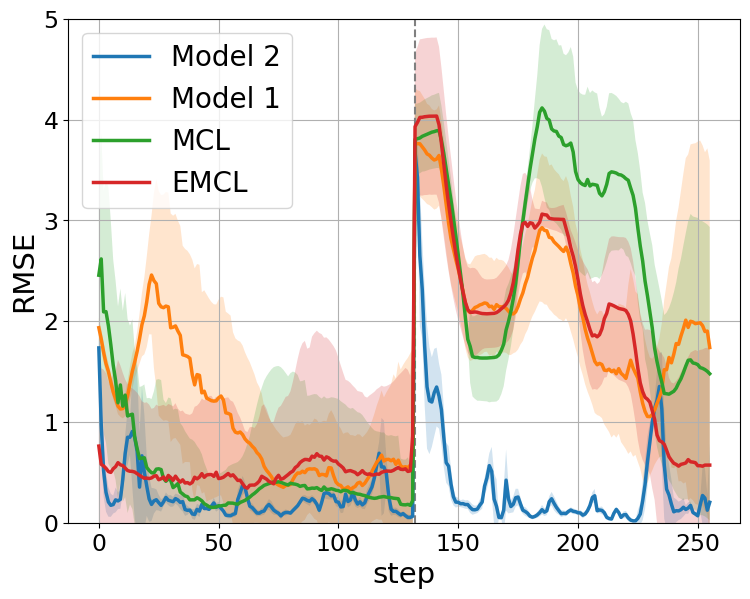

In [129]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
fontsize = 21
linewidth = 2.5

plt.figure(figsize=(8,6))
plt.axvline(x=kinapping_step, color='gray', linestyle='--')

for key, rmse_sequence in rmse_sequences.items():
    if not are_lengths_equal(rmse_sequence):
        print(key, "error")
        exit()
    
    mean= np.array(rmse_sequence).mean(axis=0)
    std_dev = np.array(rmse_sequence).std(axis=0)
    
    plt.subplots_adjust(left=0.11, right=0.95, bottom=0.11, top=0.95)
    plt.fill_between(np.arange(len(mean)),mean+std_dev, mean-std_dev, alpha=0.2)
    plt.plot(mean,label =str(key),linewidth=linewidth)

plt.ylim(0,5)
# plt.ylim(0,12)
plt.tick_params(labelsize=17)
plt.legend(fontsize=20)
plt.xlabel("step", fontsize=fontsize)
plt.ylabel("RMSE", fontsize=fontsize)
plt.grid(True)
plt.savefig('test.pdf')
plt.show()


In [130]:

from PIL import Image
import matplotlib.pyplot as plt
import yaml

map_path = '/root/TurtleBot3/catkin_ws/src/rgiro_sweethome3d_worlds/maps/type_2/3ldk/3ldk_01/map.pgm'
yaml_path = map_path.replace(".pgm", ".yaml")
# YAMLファイルを読み込む
with open(yaml_path, 'r') as file:
    map_meta_data = yaml.safe_load(file)

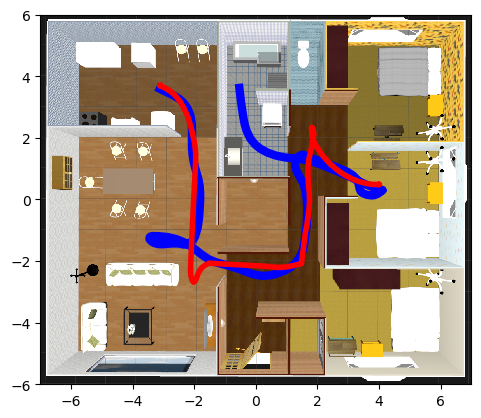

In [131]:

map_path="/root/TurtleBot3/catkin_ws/src/ros_rssm/Multimodal-RSSM/train/HF-PGM/House/MRSSM/MRSSM/room_layout_2_origin.png"
img_map=Image.open(map_path)

linewidth = 6
kidnapping_step = 132

plt.imshow(img_map, extent=(-7,7,-6,6), cmap='gray')
x = np.array(position_sequences[list(target_episode_folders.keys())[0]]['grand_pose_t'][0])[:,0]
y = np.array(position_sequences[list(target_episode_folders.keys())[0]]['grand_pose_t'][0])[:,1]

plt.plot(x[:kidnapping_step],y[:kidnapping_step], label="before kidnapping", color="b", linewidth=linewidth)
plt.plot(x[kidnapping_step:],y[kidnapping_step:], label="after kidnapping", color="r", linewidth=linewidth/1.5)
